# Example 5.1, The non linear truss

## Preliminaries

Include the required Julia packages and the files with the module definition for assembling and solving the model.
 
These are the packages of Julia repo nedded:

In [1]:
using Printf, LinearAlgebra
using IterativeSolvers, BenchmarkTools, Statistics
using PyPlot, PyCall
using MAT
;

These are the module for handling hyperdual numbers, material properties, elements and problem solution:

In [2]:
include("adiff.jl")
include("materials.jl")
include("elements.jl")
;

these are helper functions to produce the model and plot the lattice with PyPlot

In [3]:
function replicateRVE(nodes_RVE, beams_RVE, 
    a1, a2, a3, N1, N2, N3)

  nNodesRVE = length(nodes_RVE)
  newnodes = [node + a1*i1+a2*i2+a3*i3 
    for i1 in 0:N1-1 
      for i2 in 0:N2-1 
        for i3 in 0:N3-1 
          for node in nodes_RVE]
  
  newbeams = [beam .+ (i3 + i2*N3 + i1*N3*N2)*nNodesRVE
    for i1 in 0:N1-1 
      for i2 in 0:N2-1
        for i3 in 0:N3-1
          for beam in beams_RVE]

  (newnodes, newbeams)
end  

function remove_duplicates!(nodes, beams)

  dTol = 1e-5
  id_rmnodes = []
  nnodes     = length(nodes)
  
  for id1 in 1:nnodes-1
    for id2 in id1+1:nnodes
      dd = sum(abs.(nodes[id1]-nodes[id2]))
      if dd ≤ dTol
        for beam in beams
          beam[beam.==id2] .= id1
        end
        push!(id_rmnodes, id2)
      end
    end
  end
  
  sort!(unique!(id_rmnodes), rev=true)  
  for item in id_rmnodes
    for beam in beams
      beam[beam.>item] .-=1
    end
  end
  deleteat!(nodes, sort!(id_rmnodes))  
  println("found ", length(id_rmnodes), " duplicate nodes")
  return 
end

mplot3d = pyimport("mpl_toolkits.mplot3d")
function plot_model(elems::Array{T} where T,
                    nodes;
                    u     = zeros(3, length(nodes)),
                    ax    = mplot3d.Axes3D(figure()),
                    alpha = 1.0, color = :b,
                    az    = 0,   el    = 0)

  beams = [elem.nodes for elem in elems]

  for beam in beams
    n1, n2 = nodes[beam]
    u1, u2 = u[:,beam[1]], u[:,beam[2]]    

    ax.plot3D([n1[1]+u1[1], n2[1]+u2[1]], 
              [n1[2]+u1[2], n2[2]+u2[2]],
              [n1[3]+u1[3], n2[3]+u2[3]],
              markersize=1, color=color, alpha=alpha)
  end
  ax.view_init(el, az) 

  return ax
end

function write_scad_file(sFileName, nodes, beams)
# write_scad_file is a helper function that produce a text file 
# with the coordinates, the nodes and the conectivity suitable 
# for drawing the model with openscad.
# The script polyhedron_hedges.scad is needed to produce the drawings
  
  open(sFileName, "w") do file    
    @printf(file, "\$fn = 8;")
    @printf(file, "radius = 0.1;")
    @printf(file, "use <polyhedron_hedges.scad>;")
    @printf(file, "nodes = [ \n")
    for node in nodes[1:end-1]
      @printf(file, "[%.f, %.f, %.f],\n", node...)
    end
    @printf(file, "[%.f, %.f, %.f]];\n", nodes[end]...)
    @printf(file, "edges = [\n")
    for beam in beams
      @printf(file, "[%i, %i],\n", beam...)
    end
    @printf(file, "[%i, %i]];", beams[end]...)
    @printf(file, "polyhedron_hedges(nodes, edges, radius);")
  end
end
;

## Model assembly

In the following cell the definition of the unit cell, the coordinates of the nodes and the connectivity

In [4]:
L0    = √2/2
nodes_RVE = [[0, 0, -√2/2],
    [0, 0, √2/2],
    [-1/2, -1/2, 0],
    [1/2, -1/2, 0],
    [1/2, 1/2, 0],
    [-1/2, 1/2, 0],
    [0, -1, √2/2],
    [1, 0, √2/2],
    [0, 1, √2/2],
    [-1, 0, √2/2],
    [0, -1, -√2/2],
    [1, 0, -√2/2],
    [0, 1, -√2/2],
    [-1, 0, -√2/2]] * L0
beams_RVE = [[9 5], [7 3], [8 4], [10 3], 
  [7 4], [9 6], [8 5], [10 6],
  [1 3], [1 4], [1 5], [1 6], [11 3],
  [13 5], [2 3], [2 4], [2 5], [2 6],
  [3 4], [4 5], [5 6], [6 3], [7 2], [8 2],
  [9 2], [10 2], [11 1],
  [12 1], [12 4], [12 5], [13 1], [13 6],
  [14 1], [14 3], [11 4], [14 6]]
R      = zeros(3,3)
R[1,:] = [√2/2, √2/2, 0]
R[2,:] = [√2/2, -√2/2, 0]
R[3,:] = [0, 0, 1]

nodes_RVE  = [R*v - [√2/2, √2/2, -√2/2]L0 for v in nodes_RVE]
;

- the following cell replicates the unit cell along directions a1, a2 and a3, for N1, N2 and N3 times respectively, taking care of removing the duplicate nodes that are created during replication 

In [5]:
a1 = [1, 0, 0]
a2 = [0, 1, 0]
a3 = [0, 0, 1]

N1 = 2
N2 = 2
N3 = 10

(nodes, beams) = replicateRVE(nodes_RVE, beams_RVE, a1, a2, a3, N1, N2, N3)
remove_duplicates!(nodes, beams)

cg = mean(nodes)
for node in nodes; node .-=cg; end  

beams = [beam[:] for beam in beams]
;

found 297 duplicate nodes


- print some detail of the model and find the node on the top and the bottom side, where boundary conditions should be applied

In [6]:
@show (minx, maxx) = extrema([node[1] for node in nodes])
@show (miny, maxy) = extrema([node[2] for node in nodes])
@show (minz, maxz) = extrema([node[3] for node in nodes])


idbtm = findall(abs.([node[3] for node in nodes].-minz) .<1e-6)
idtop = findall(abs.([node[3] for node in nodes].-maxz) .<1e-6)
;

(minx, maxx) = extrema([node[1] for node = nodes]) = (-1.0000000000000002, 1.0)
(miny, maxy) = extrema([node[2] for node = nodes]) = (-1.0000000000000002, 1.0)
(minz, maxz) = extrema([node[3] for node = nodes]) = (-5.0, 5.0)


Assemble the vector with the elements, assigning cross section area and material properties

In [7]:
A = .01
elems = [Elements.Rod(beam[:], nodes[beam[:],:], A, mat=Materials.Hooke(1, 0.3)) 
  for beam in beams]
;

- Plot the undeformed model

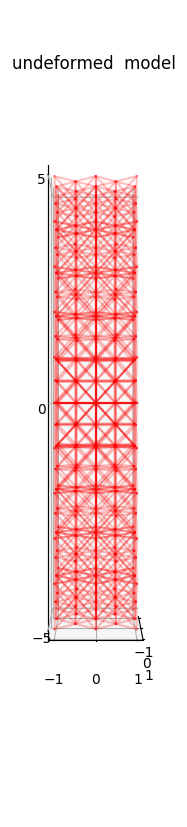

In [8]:
ax = mplot3d.Axes3D(figure(figsize=(2,8)))
plot_model(elems, nodes,
  ax = ax, color = :r, alpha=0.25)
title("undeformed  model")

ax.set_aspect(N3/N2)
;

## Problem statement and solution

make room for nodal displacement and the Lagrange multipliers vectors, and initialize them
- u0 is the array with the nodal degrees of freedom
- $\lambda$ is the array with the lagrange multipliers
- ifree is an array of boolean marking the free DoFs

In [9]:
nNodes    = length(nodes)
u0        = zeros(3, nNodes)                       # initial values for the nodal displacements
λ         = zeros(length(idtop)+length(idbtm))     # initial values for the lagrange multipliers
ifree     = trues(3, nNodes)                       # there are no prescribed DoFs 
;

- divide the problem in 7 increments, for different value of the rotation angle between $\pi$/8 and 7$\pi$/8
- $\theta$ is the array with incremental boundary condition 
- eqns is the array with the constraint equation, we have one equation for each each node on the top and the bottom, the nodes are constrained to remain on planes that rotate at each increment, for this reason the equations need to be updated at each increment


The for loop update the solution for each value of $\theta$, u0 and $\lambda$ ar updated in place, therefore the solution is copyed in a vector at each increment, also for each increment an openscad file is produced for drawing the deformed shape

- The first call to Elements.solvestep! takes longer because of compilation time

In [10]:
# θ = range(π/8, 7π/8, length=4) # the problem can be solved also on fewer increments
θ = range(π/8, 7π/8, length=7)

for (ii,θ) in enumerate(θ)
  # update constraint equations with a new θ
  eqns_top = [Elements.ConstEq(x-> [0, sin(θ), cos(θ)]⋅(nodes[ii]+x[1:3])-maxz, 
      LinearIndices(u0)[:,ii]) for ii in idtop]
  eqns_btm = [Elements.ConstEq(x-> [0, sin(-θ), cos(-θ)]⋅(nodes[ii]+x[1:3])-minz, 
      LinearIndices(u0)[:,ii]) for ii in idbtm]
  eqns = vcat(eqns_top, eqns_btm)
  
  # solve the current step
  tic = Base.time_ns()
  (bfailed, normr, iter) = Elements.solvestep!(elems, u0, ifree, λ=λ, eqns=eqns, 
    dTol=1e-6, becho=false)
  toc = Int64(Base.time_ns()-tic)/1e9
  
  if bfailed
    println("failed, normr: ", normr, ", θ: ", θ/π) 
    break
  else
    global lastu = copy(u0)
    sFileName = @sprintf("%s_%02i.scad", "truss_3X2X10_def", ceil(Int, ii))
    write_scad_file(sFileName, [nodes[ii]+u0[:,ii] for ii in 1:nNodes], beams)    
    println("step: ", ii, " done in ", iter, " iterations in ", toc, " sec.")
  end
end
;

step: 1 done in 3 iterations in 9.780808137 sec.
step: 2 done in 3 iterations in 0.713542085 sec.
step: 3 done in 3 iterations in 0.404226693 sec.
step: 4 done in 3 iterations in 0.552893446 sec.
step: 5 done in 3 iterations in 0.592039252 sec.
step: 6 done in 3 iterations in 0.414014525 sec.
step: 7 done in 3 iterations in 0.537487344 sec.


- plot the last deformed shape

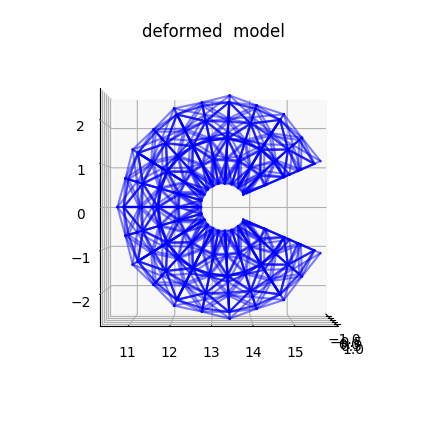

In [11]:
ax = mplot3d.Axes3D(figure(figsize=(4,4)))
plot_model(elems, nodes,
  u = u0,
  ax = ax, color = :b, alpha=0.5)
title("deformed  model")
;

Repeat the calculations with a larger model

In [12]:
N1 = 3
N2 = 2
N3 = 30

(nodes_2, beams_2) = replicateRVE(nodes_RVE, beams_RVE, a1, a2, a3, N1, N2, N3)
remove_duplicates!(nodes_2, beams_2)

cg = mean(nodes_2)
for node in nodes_2; node .-=cg; end  

beams_2 = [beam[:] for beam in beams_2]

@show (minx, maxx) = extrema([node[1] for node in nodes_2])
@show (miny, maxy) = extrema([node[2] for node in nodes_2])
@show (minz, maxz) = extrema([node[3] for node in nodes_2])
println()

idbtm = findall(abs.([node[3] for node in nodes_2].-minz) .<1e-6)
idtop = findall(abs.([node[3] for node in nodes_2].-maxz) .<1e-6)

A = .01
elems_2 = [Elements.Rod(beam[:], nodes_2[beam[:],:], A, mat=Materials.Hooke(1, 0.3)) 
         for beam in beams_2]

nnodes_2  = length(nodes_2)
u0_2      = zeros(3, nnodes_2)                       # initial values for the nodal displacements
λ         = zeros(length(idtop)+length(idbtm))       # initial values for the lagrange multipliers
ifree     = trues(3, nnodes_2)                       # there are no prescribed DoFs 
θ         = range(π/8, 7π/8, length=7)

for (ii, θ) in enumerate(θ)
  # update constraint equations with a new θ
  eqns_top = [Elements.ConstEq(x-> [0, sin(θ), cos(θ)]⋅(nodes_2[ii]+x[1:3])-maxz, 
                               LinearIndices(u0_2)[:,ii]) for ii in idtop]
  eqns_btm = [Elements.ConstEq(x-> [0, sin(-θ), cos(-θ)]⋅(nodes_2[ii]+x[1:3])-minz, 
                               LinearIndices(u0_2)[:,ii]) for ii in idbtm]
  eqns = vcat(eqns_top, eqns_btm)

  # solve the current step
  tic = Base.time_ns()
  (bfailed, normr, iter) = Elements.solvestep!(elems_2, u0_2, ifree, λ=λ, eqns=eqns, 
                                               dTol=1e-6, becho=false)
  toc = Int64(Base.time_ns()-tic)/1e9

  if bfailed
    println("failed, normr: ", normr, ", θ: ", θ/π) 
    break
  else
    global lastu = copy(u0_2)
    sFileName = @sprintf("%s_%02i.scad", "truss_3X2X10_def", ceil(Int, ii))
    write_scad_file(sFileName, [nodes_2[ii]+u0_2[:,ii] for ii in 1:nnodes_2], beams_2)    
    println("step: ", ii, " done in ", iter, " iterations in ", toc, " sec.")
  end
end
;

found 1452 duplicate nodes
(minx, maxx) = extrema([node[1] for node = nodes_2]) = (-1.5000000000000002, 1.5)
(miny, maxy) = extrema([node[2] for node = nodes_2]) = (-1.0000000000000002, 1.0)
(minz, maxz) = extrema([node[3] for node = nodes_2]) = (-15.0, 15.0)

step: 1 done in 3 iterations in 6.496056814 sec.
step: 2 done in 3 iterations in 7.170477232 sec.
step: 3 done in 3 iterations in 7.202375122 sec.
step: 4 done in 3 iterations in 7.832053889 sec.
step: 5 done in 3 iterations in 7.738302935 sec.
step: 6 done in 3 iterations in 8.134285491 sec.
step: 7 done in 3 iterations in 7.147563807 sec.


- plot the deformed model

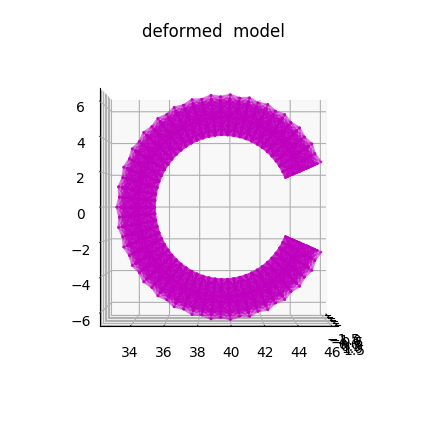

In [16]:
ax = mplot3d.Axes3D(figure(figsize=(4,4)))
plot_model(elems_2, nodes_2,
  u = u0_2,
  ax = ax, color = :m, alpha=0.5)
title("deformed  model")
;